## A/B–тестирование
В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. Необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

В качестве входных данных имеются 4 csv-файла:

* groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
* groups_add.csv - дополнительный файл с пользователями, который был прислан спустя 2 дня после передачи данных
* active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
* checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt

In [2]:
# создам кастомную функцию стилей графиков на основе seaborn.set_theme()
def set_style(style='whitegrid', rc=None, palette='deep', xticks='on', yticks='off', default_rc=False):
    if default_rc:
        plt.style.use('default')
        user_rc = {'grid.color': 'f0f0f0'}
    else:
        user_rc = {'figure.figsize': (18, 10), 'axes.titlesize': 20, 'axes.labelsize': 18, 
                   'xtick.labelsize': 12, 'ytick.labelsize': 12, 'axes.titlepad': 30, 
                   'lines.linewidth': 3.5, 'figure.dpi': 120, 'grid.color': 'f0f0f0', 
                   'legend.fontsize': 14.0, 'legend.title_fontsize': 16.0, 'legend.frameon': False}
    
    if xticks == 'on':
        user_rc |= {'xtick.bottom': True, 'xtick.minor.visible': False}
        
    if yticks == 'on':
        user_rc |= {'ytick.left': True}
    
    sns.set_theme(style=style, rc=user_rc, palette=palette)

In [3]:
set_style()

## Задание №1. A/B–тестирование. 
### Предобработка данных
Загружаю датафреймы

In [4]:
groups = pd.read_csv('groups.csv', sep=';')
groups.head(2)

,id,grp
0,1489,B
1,1627,A


In [5]:
# пропущенных значений нет
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [6]:
groups_add = pd.read_csv('groups_add.csv')
groups_add.head(2)

,id,grp
0,5694584,B
1,5694830,B


In [7]:
# пропущенных значений нет
groups_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [8]:
active_studs = pd.read_csv('active_studs.csv')
active_studs.head(2)

,student_id
0,581585
1,5723133


In [9]:
# пропущенных значений нет
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [10]:
checks = pd.read_csv('checks.csv', sep=';')
checks.head(2)

,student_id,rev
0,1627,990.0
1,3185,690.0


In [11]:
# пропущенных значений нет
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


Теперь надо смерджить таблицы, чтобы анализировать результаты А/Б теста. Но перед этим посмотрим на таблицу `checks`. В ней содержится информация о revenue. 

In [12]:
# Обнаружил, что есть ревенью 1900.0001 
checks.rev.unique()

array([ 990.    ,  690.    ,  630.    ,  580.    ,  290.    , 1140.    ,
       1900.0001,  199.    ,  398.    , 1830.    , 1900.    , 3260.    ,
       2910.    , 2820.    , 2099.    , 3660.    , 1530.    , 2900.    ,
       1980.    , 1160.    ,  870.    ,  840.    , 2890.    , 1180.    ,
        880.    , 3040.    ,  796.    , 4650.    , 2190.    , 1729.    ,
       1388.    ,  590.    , 2220.    ,  489.    , 1050.    , 1968.    ,
       1339.    ,  597.    , 1039.    ])

Это, возможно, ошибка. В любом, случае, решил избавиться от хвоста. Он слишком мал, чтобы на что-то влиять. А избавление позволит упростить анализ

In [13]:
# избавляюсь от хвоста:
checks.rev = checks.rev.apply(lambda x: int(x))
checks.head(2)

,student_id,rev
0,1627,990
1,3185,690


У остальных колонок проблем нет. Но нужно еще сделать несколько преобразование перед мерджем.

Во-первых, соединить таблицы `groups` и `groups_add` (так как `groups_add` это дополнение к `groups`), создав таблицу `grs`.

In [14]:
grs = pd.concat([groups, groups_add], ignore_index=True)

Во-вторых, добавить колонку `active`в `active_studs`. Там в дальнейшем будет информация об активных/неактивных пользователях

In [15]:
active_studs['active'] = 1

А в-третьих, привести все айдишники к общему названию - по этой колонке и будем мерджить

In [16]:
active_studs.rename(columns={'student_id': 'id'}, inplace=True)
checks.rename(columns={'student_id': 'id'}, inplace=True)

Теперь можно мерджить

In [17]:
grs = grs.merge(active_studs, on='id', how='left')
grs = grs.merge(checks, on='id', how='left')
grs.head(3)

,id,grp,active,rev
0,1489,B,NaN,NaN
1,1627,A,1.0,990.0
2,1768,B,NaN,NaN


In [18]:
# Заменяем NaN на нули и приводим данные "active" и "rev" к удобному числовому формату
grs.loc[grs.active.isna(), 'active'] = 0
grs.loc[grs.rev.isna(), 'rev'] = 0
grs.active = pd.to_numeric(grs.active, downcast='integer')
grs.rev = pd.to_numeric(grs.rev, downcast='integer')
grs.head(2)

,id,grp,active,rev
0,1489,B,0,0
1,1627,A,1,990


Посмотрим внимательно на получившуюся таблица `grs`. Часть из тех, кто зашел на сайт во время эксперимента (active = 1), оплатили. Но есть и те, кто не заходил на сайт во время эксперимента, но тоже оплатили:

In [19]:
# таких 149 человек:
grs.query("rev != 0 and active == 0")

,id,grp,active,rev
39,3185,B,0,690
121,25973,B,0,690
125,26280,B,0,690
223,100645,B,0,630
254,102534,B,0,580
...,...,...,...,...
72452,5291900,B,0,199
72753,5331842,B,0,290
73632,5486319,B,0,199
74049,5562806,B,0,398


Можно предположить, что у них сессия взаимодействия с сайтом началась раньше старта эксперимента. Поэтому система не посчитала их заход на сайт, но посчитала покупку, так как покупка произошла уже во время эксперимента.

Таких нужно удалить ибо они по сути не участвовали в эксперименте. Но тут встает вопрос: а что делать с теми из них, кого отнесли к контрольной группе? Ведь они, получается, видели старую версию оплаты, а значит могут считаться частью контрольной группы. НО! Они это делали ДО эксперимента, а поэтому, строго говоря, их нельзя относить к эсперименту хотя бы потому, что они дейстовали в другом временном промежутке. Поэтому просто исключаем.

In [20]:
out_of_experiment = grs.query("rev != 0 and active == 0").id

In [21]:
grs = grs.query("id not in @out_of_experiment")

### А/Б тест

Итак, у нас есть таблица, с которой можно работать и анализировать итоги А/Б теста

In [22]:
grs.head(3)

,id,grp,active,rev
0,1489,B,0,0
1,1627,A,1,990
2,1768,B,0,0


Можно выделить три уровня пользователей: все, активные (кто зашел на сайт) и купившие.

На что могло повлиять обновление страницы оплаты на сайте? На конверсию в покупку и на доход. Это и будем проверять. Для этого используем метрики:
* CR активных в покупку
* ARPU в широком смысле. 

В рамках ARPU посмотрим на:
* ARPPU (здесь это средний доход на заплатившего пользователя). Позволит понять, есть ли влияние на суммы, которые в среднем потратили оплатившие пользователи
* ARPAU - более общая метрика, по сути включит в себя еще и влияние CR
* И, собственно, ARPU - поможет оценить общий эффект от изменений (если он есть)

#### Начнем с активных

In [23]:
# таблица с активными
active = grs.query("active == 1").copy()

#### Посмотрим разницу между CR обеих групп

In [24]:
# таблица для оценки CR
active_exp1 = active.loc[:, ['id', 'grp', 'rev']]
active_exp1.head(2)

,id,grp,rev
1,1627,A,990
10,2085,B,0


Добавим категориальную переменную "purhase", которая будет принимать два значения: 1 (купил) и 0 (не купил).

In [25]:
active_exp1['purhase'] = active_exp1.rev.apply(lambda x: 1 if x > 0 else 0)
del active_exp1['rev']  # удалим rev, чтоб не мешалась
active_exp1.head(2)

,id,grp,purhase
1,1627,A,1
10,2085,B,0


In [26]:
active_exp1.query("grp == 'A'").purhase.mean()  # средний CR группы "А"

0.05071521456436931

In [27]:
active_exp1.query("grp == 'B'").purhase.mean()  # средний CR группы "В"

0.046156107599588415

На первый взгляд конверсии различаются, хоть и незначительно. Проверим, статзначимое ли это различие. Переменные здесь категориальные, поэтому используем хи-квадрат или критерий согласия Пирсона.

In [28]:
pd.crosstab(active_exp1.grp, active_exp1.purhase)  # строим таблицу сопряженности

purhase,0,1
grp,,
A,1460,78
B,6489,314


In [29]:
st.chi2_contingency(pd.crosstab(active_exp1.grp, active_exp1.purhase))[1]  # p-value

0.48625240457231045

P-value больше любых традиционных уровней значимости. Cтатистически значимые результаты не получены. То есть, мы не можем отклонить нулевую гипотезу о том, что нет никакой зависимости между принадлежности к группе и CR активных пользователей в покупку. А значит будем считать, что различий в CR нет.

#### Посмотрим разницу между ARPPU обеих групп

In [30]:
# таблица для оценки ARPPU
active_exp2 = active.loc[:, ['id', 'grp', 'rev']].copy()
active_exp2 = active_exp2.query("rev != 0")
active_exp2.head(3)

,id,grp,rev
1,1627,A,990
220,100300,B,990
320,108270,B,290


Посмотрим на распределение оплат в разных группах

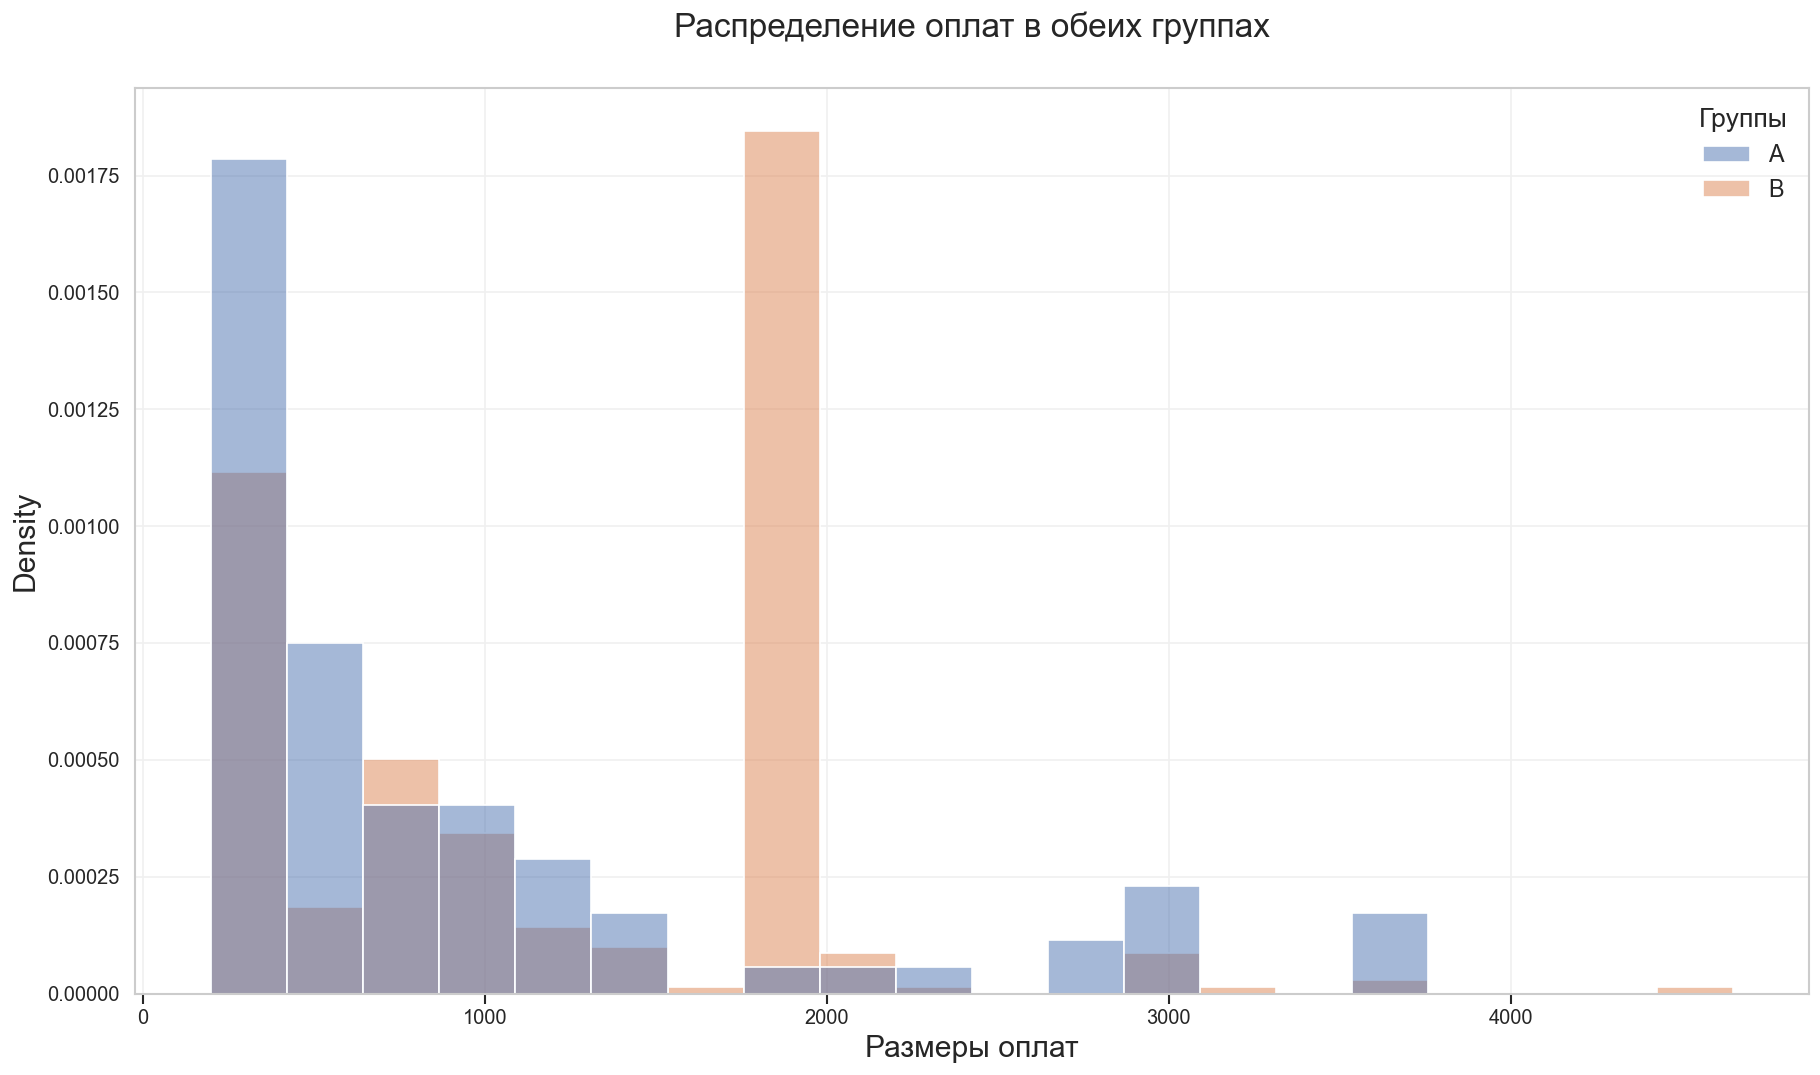

In [31]:
ax = sns.histplot(data=active_exp2, 
                  x='rev', 
                  hue='grp', 
                  bins=20, 
                  stat="density", 
                  common_norm=False)
ax.set(title='Распределение оплат в обеих группах', xlabel='Размеры оплат')
ax.legend_.set_title('Группы')

В глаза бросается столбец с оплатами около 2000 в группе B.

Посмотрим какие оплаты преобладали в разных группах.

In [32]:
active_exp2.query("grp == 'A'").rev.value_counts().head()

290    25
580     6
990     5
199     5
590     5
Name: rev, dtype: int64

In [33]:
active_exp2.query("grp == 'B'").rev.value_counts().head()

1900    128
290      45
199      27
840      21
990      17
Name: rev, dtype: int64

Видим, что оплата в 1900 была очень популярна в группе B. При этом в группе A таких оплат не было вовсе.

Такой столбец в группе B явно должен повлиять на результаты. Посмотрим!

Как видим из предыдущего графика, данные далеки от нормальных. По идее, можно использовать тест Манна-Уитни. Но в наших данных очень много повторяющихся значений, что не очень хорошо сказывается на тесте Манна-Уитни. Поэтому лучше будем использовать Бутстрап. Он всеяден. Его основная проблема - потребляет много ресурсов. Но так как датасет у нас относительно небольшой, то Бутстрап в нашем случае пройдет легко.

#### Объявим функцию бутстрапирования:

In [34]:
def get_bootstrap(data_column_1, data_column_2, boot_it=1000, statistic=np.mean, bootstrap_conf_level=0.95,
                  plot='on', seed=None):
    if seed:
        np.random.seed(seed)
        
    boot_len = max([len(data_column_1), len(data_column_2)])
    
    boot_data = []

    for i in range(boot_it):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(boot_len, replace=True).values
        samples_2 = data_column_2.sample(boot_len, replace=True).values
        
        boot_data.append(statistic(samples_1) - statistic(samples_2))  # применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = st.norm.cdf(x=0, loc=np.mean(boot_data), scale=np.std(boot_data))
    p_2 = st.norm.cdf(x=0, loc=-np.mean(boot_data), scale=np.std(boot_data))
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.style.use('ggplot')
    if plot == 'on':
        _, _, bars = plt.hist(pd_boot_data[0], bins=50)
        for bar in bars:
            if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
                bar.set_facecolor('red')
            else: 
                bar.set_facecolor('grey')
                bar.set_edgecolor('black')

        plt.vlines(quants, ymin=0, ymax=500, linestyle='--')
        plt.xlabel('boot_data')
        plt.ylabel('frequency')
        plt.title("Histogram of boot_data")
        plt.show()
       
    return {"boot_data": boot_data, "quants": quants, "p_value": p_value}

#### Бутстрап ARPPU

In [35]:
a = active_exp2.query("grp == 'A'").rev
b = active_exp2.query("grp == 'B'").rev

In [36]:
a.mean()  # ARPPU  в группе А

933.5897435897435

In [37]:
b.mean()  # ARPPU  в группе B

1257.8789808917197

Видно, что ARPPU в группах различаются. Но статзначимо ли это различие?

In [38]:
set_style(default_rc=True)

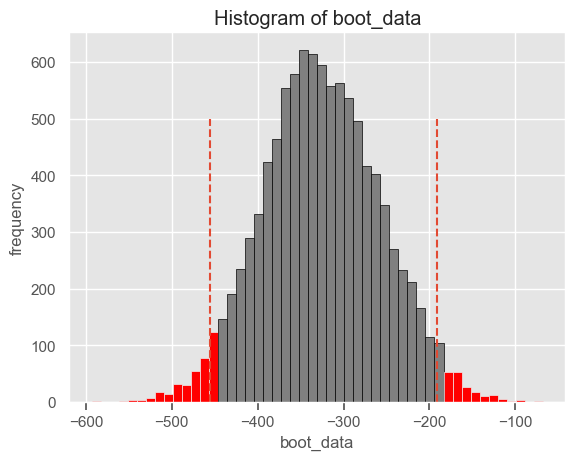

In [39]:
bootstrap = get_bootstrap(a, b, bootstrap_conf_level=0.95, boot_it=10000, seed=5)

In [40]:
bootstrap['p_value']

1.8724489828874039e-06

Различия оказались статзначимы, причем p-value очень низкое, что дает основания отклонить нулевую гепотезу и принять альтернативную, что различия ARPPU между группами есть.

#### Бутстрап ARPPU без 1900

In [41]:
active_exp2_clean = active_exp2.query("rev != 1900")  # таблица для ARPPU БЕЗ 1900

In [42]:
a = active_exp2_clean.query("grp == 'A'").rev
b = active_exp2_clean.query("grp == 'B'").rev

In [43]:
a.mean()

933.5897435897435

In [44]:
b.mean()

815.989247311828

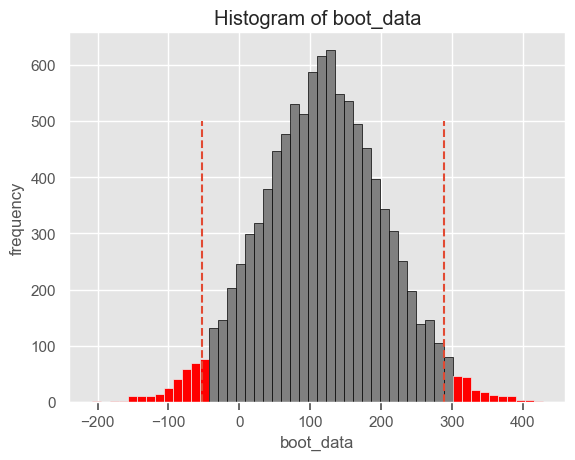

In [45]:
bootstrap = get_bootstrap(a, b, boot_it=10000, seed=5)

In [46]:
bootstrap['quants']

,0
0.025,-52.951344
0.975,288.561962


In [47]:
bootstrap['p_value']

0.176042630190677

Разница не статзначима, нулевую гепотезу не отклоняем, то есть, различия в ARPPU без 1900 между группами найдено не было. Оплаты в 1900 пользователями сильно повлияли на результаты. Возможно, что-то заставило пользователей на новой странице делать оплаты на эту сумму, и это, возможно, и есть особенность новой страницы оплаты.

Идем дальше

#### Бутстрап ARPAU

In [48]:
active_exp3 = active.loc[:, ['id', 'grp', 'rev']]  # Таблица для оценки ARPAU
active_exp3.head(3)

,id,grp,rev
1,1627,A,990
10,2085,B,0
12,2215,B,0


In [49]:
a = active_exp3.query("grp == 'A'").rev
b = active_exp3.query("grp == 'B'").rev

In [50]:
a.mean()  # ARPAU группы "А"

47.34720416124838

In [51]:
b.mean()  # ARPAU группы "B"

58.05879758929884

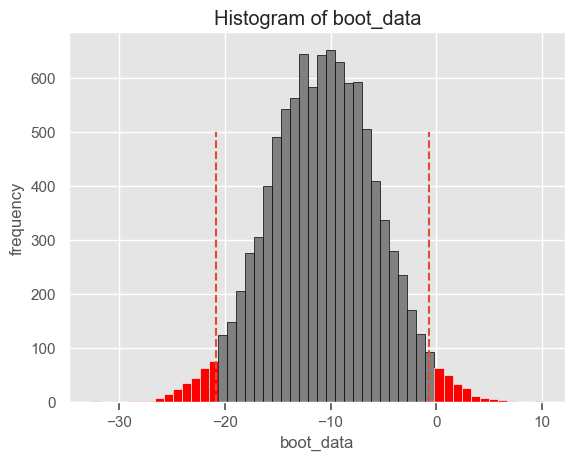

In [52]:
bootstrap = get_bootstrap(a, b, bootstrap_conf_level=0.95, boot_it=10000, seed=5)

In [53]:
bootstrap['p_value']

0.037454943905315334

При уровне значимости 5% различия статзначимы. Принимаем, что ARPAU у групп различаются.

#### Проверим теперь разницу в ARPU

In [54]:
all_users = grs.loc[:, ['id', 'grp', 'rev']]
all_users.head(3)

,id,grp,rev
0,1489,B,0
1,1627,A,990
2,1768,B,0


In [55]:
a = all_users.query("grp == 'A'").rev
b = all_users.query("grp == 'B'").rev

In [56]:
a.mean()  # ARPU группы "А"

4.965902891434807

In [57]:
b.mean()  # ARPU группы "B"

6.609005572009437

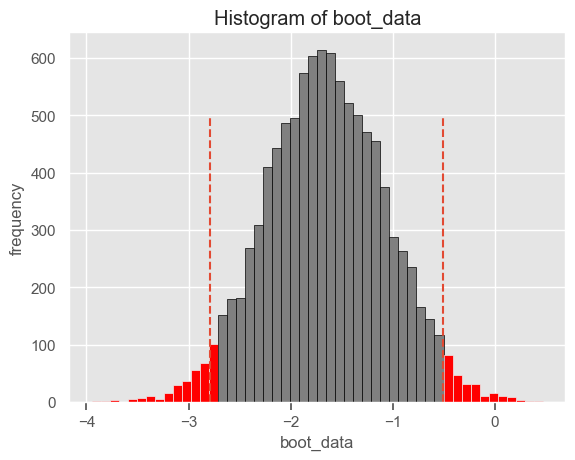

In [58]:
bootstrap = get_bootstrap(a, b, bootstrap_conf_level=0.95, boot_it=10000, seed=5)

In [59]:
bootstrap['quants']

,0
0.025,-2.786557
0.975,-0.510863


In [60]:
bootstrap['p_value']

0.004898648611264053

Получили уверенную статзначимость результатов. Примем альтернативную гипотезу, что ARPU групп различаются.

Итак, проверили все метрики. Но прежде, чем делать окончательные выводы, проверим еще одну вещь.

Заметил, что p-value разницы в ARPU ниже, чем разницы в ARPAU. Это по идее не логично, потому что с увеличением уровня юзеров p-value должен бы наоборот расти. Можно предположить, что что-то не так с конверсией из простого юзера в активные (зашедшие на сайт). Проверим.

In [61]:
a = grs.query("grp == 'A'").active
b = grs.query("grp == 'B'").active

In [62]:
a.mean()  # конверсия контрольной группы

0.10488270594653573

In [63]:
b.mean()  # тестовой контрольной группы

0.11383297357897026

Как видим, есть разница между конверсиями групп. Но статзначима ли она?

Проверять будем с помощью хи-квардрата, как и в случае с CR из активных в покупку.

In [64]:
pd.crosstab(grs.grp, grs.active)  # таблица сопряженности

active,0,1
grp,,
A,13126,1538
B,52960,6803


In [65]:
st.chi2_contingency(pd.crosstab(grs.grp, grs.active))[1]

0.002182661490321881

Разница оказалась статзначимой. А этого, по идее, быть не должно.

### Выводы

Итак, получается, что по ARPPU тестовая группа твердо выигрывает. При этом статзначимую разницу в конверсиях из активных в продажи между группами мы не нашли. То есть новая страница оплаты не побуждает большее количество юзеров покупать. Но она побуждает больше платить.

Но вот, что интересно: 

1. Есть интересные оплаты на 1900 у тестовой группы. Таких оплат нет у контрольной. И без этих оплат статзначимой разницы в ARPPU найдено не было. Мы, конечно, не знаем, как повели бы себя пользователи, если бы у них не было возможности купить на 1900. Но в данном конкретном случае именно эти оплаты сдвинули ARPPU в тестовой группе в большую сторону, и тестовое ARPPU в итоге стало статзначимо больше контрольной ARPPU. Это хорошо видно по графику распределений оплат: других выделяющихся столбцов у тестовой группы не было, и роста других крупных покупок (выше ARPPU контрольной группы) не произошло. За исключением нескольких оплат, у тестовой группы даже меньше крупных оплат, чем у контрольной. В итоге, надо обратить пристальное внимание на эти оплаты в 1900 и как они связаны с изменением механики оплаты на сайте.
    
2. По какой-то причине конверсия в активные (кто зашел на сайт) статзначимо отличается в группах, чего быть по идее не должно, так как группы должны быть однородны по своему поведению, на которое не влияет наш эксперимент. А новая фича никак не может влиять на вероятность захода на сайт.

Учитывая вышесказанное, несмотря на то, что были найдены статзначимые различия в ARPU в пользу тестовой группы, не могу пока рекомендовать запускать новую механику оплаты на всех пользователей. Необходимо сначала понять, почему группы так сильно различаются по конверсии в активных (возможно, проблемы с системой сплитования). А также вопрос с оплатами в 1900, почему именно они способствовали возросшей ARPPU в тестовой группе, это закономерное влияние новой механики оплат и так и задумывалось или же просто баг?